# Summary
- Analysis of fine-tuned models

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns
from ipywidgets import FloatSlider, interactive
import sys
sys.path.append('..')
from var import fname2mname, network2pair, network_sort_key

In [5]:
# loading in them all made my machine run out of memory
method_l = [
     "maxcorr", 
     "mincorr", 
     "maxlinreg", 
     "minlinreg", 
    "cca", 
    "lincka", 
    # "rbfcka",
]

In [6]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/belinkov/contextual-corr-analysis/repr_fine_results1_"
res_fname = {method : base + method for method in 
                method_l}

res_d = {}
for method in method_l:
    with open(res_fname[method], 'rb') as f:
        res_d[method] = pickle.load(f)

network_l = [network for network in res_d["cca"]["corrs"]]
network_l = sorted(network_l, key=network_sort_key)

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(next(iter(res_d["cca"]["corrs"][network].values()))) # god this is a hack

In [7]:
network_l

['bert_base_uncased-ptb_pos_dev.hdf5_0',
 'bert_base_uncased-ptb_pos_dev.hdf5_1',
 'bert_base_uncased-ptb_pos_dev.hdf5_2',
 'bert_base_uncased-ptb_pos_dev.hdf5_3',
 'bert_base_uncased-ptb_pos_dev.hdf5_4',
 'bert_base_uncased-ptb_pos_dev.hdf5_5',
 'bert_base_uncased-ptb_pos_dev.hdf5_6',
 'bert_base_uncased-ptb_pos_dev.hdf5_7',
 'bert_base_uncased-ptb_pos_dev.hdf5_8',
 'bert_base_uncased-ptb_pos_dev.hdf5_9',
 'bert_base_uncased-ptb_pos_dev.hdf5_10',
 'bert_base_uncased-ptb_pos_dev.hdf5_11',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_0',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_1',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_2',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_3',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_4',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_5',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_6',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_7',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_8',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_9',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_10',

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [8]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [9]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = res_d[method]["neuron_sort"][network]

In [10]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [11]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

bert_base_uncased-ptb_pos_dev.hdf5_0
            maxcorr   mincorr  maxlinreg  minlinreg
maxcorr    1.000000  0.214047   0.835308   0.338987
mincorr    0.214047  1.000000   0.195996   0.413221
maxlinreg  0.835308  0.195996   1.000000   0.313669
minlinreg  0.338987  0.413221   0.313669   1.000000
bert_base_uncased-ptb_pos_dev.hdf5_1
            maxcorr   mincorr  maxlinreg  minlinreg
maxcorr    1.000000 -0.177983   0.831154   0.070034
mincorr   -0.177983  1.000000  -0.150774   0.421783
maxlinreg  0.831154 -0.150774   1.000000   0.154694
minlinreg  0.070034  0.421783   0.154694   1.000000
bert_base_uncased-ptb_pos_dev.hdf5_2
            maxcorr   mincorr  maxlinreg  minlinreg
maxcorr    1.000000 -0.161110   0.932017   0.182813
mincorr   -0.161110  1.000000  -0.158037   0.404584
maxlinreg  0.932017 -0.158037   1.000000   0.225499
minlinreg  0.182813  0.404584   0.225499   1.000000
bert_base_uncased-ptb_pos_dev.hdf5_3
            maxcorr   mincorr  maxlinreg  minlinreg
maxcorr    1.000000 

### Distributions

In [12]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        if method == "maxlinreg" or method == "minlinreg": 
            corr_df = pd.DataFrame(res_d[method]['pred_power'][network])
        else:
            corr_df = pd.DataFrame(res_d[method]['corrs'][network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



bert_base_uncased-ptb_pos_dev.hdf5_0:

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0    762
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0        5
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0       1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.214055  0.090236
min  0.214055  1.000000  0.062222
med  0.090236  0.062222  1.000000

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0    762
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0        5
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0       1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.214055  0.090236
min  0.214055  1.000000  0.062222
med  0.090236  0.062222  1.000000

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    7

         max       min       med
max  1.00000  0.102750  0.966890
min  0.10275  1.000000  0.080279
med  0.96689  0.080279  1.000000

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_7          445
bert_base_uncased-ptb_pos_dev.hdf5_5          322
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_6      1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    766
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10      2
dtype: int64

corr_df_pctl
         max       min       med
max  1.00000  0.102750  0.966890
min  0.10275  1.000000  0.080279
med  0.96689  0.080279  1.000000

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_7    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    767
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0        1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.667757  0.977794
min  0.667757  1.000000  0.707989
med  0.977794  0.707989  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_7

bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.469982  0.395974
min  0.469982  1.000000  0.676651
med  0.395974  0.676651  1.000000


bert_base_uncased-ptb_pos_dev_mnli.hdf5_1:

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_2     437
bert_base_uncased-ptb_pos_dev.hdf5_1          316
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_1      6
bert_base_uncased-ptb_pos_dev_qnli.hdf5_1       5
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0       3
bert_base_uncased-ptb_pos_dev_qqp.hdf5_1        1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.053983  0.857672
min -0.053983  1.000000 -0.036150
med  0.857672 -0.036150  1.000000

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_2     437
bert_base_uncased-ptb_pos_dev.hdf5_1          316
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_1      6
bert_base_unc


maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_8    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    727
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0       16
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0       15
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0        10
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.610565  0.873033
min  0.610565  1.000000  0.774764
med  0.873033  0.774764  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_8    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    727
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0       16
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0       15
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0        10
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.610565  0.873033
min  0.610565  1.000000  0.774764
med  0.873033  0.774764  1.000000


bert_base_uncased-ptb_pos_dev_mnli.hdf5_8:

maxcorr

maxcounts
bert_base_uncased-ptb_


maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0      241
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0      239
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0       187
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11     78
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0      23
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.357984  0.549933
min  0.357984  1.000000  0.754549
med  0.549933  0.754549  1.000000


bert_base_uncased-ptb_pos_dev_mnli.hdf5_11:

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_10    760
bert_base_uncased-ptb_pos_dev_mnli.hdf5_9       8
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    374
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0       89
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0       53
bert_base_uncased-ptb_pos_dev_qqp.hdf5_3        40
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0        38
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0      36
b

bert_base_uncased-ptb_pos_dev.hdf5_2         666
bert_base_uncased-ptb_pos_dev_qnli.hdf5_1     62
bert_base_uncased-ptb_pos_dev_qnli.hdf5_3     39
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2       1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.154052  0.902930
min -0.154052  1.000000 -0.136802
med  0.902930 -0.136802  1.000000

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_2         666
bert_base_uncased-ptb_pos_dev_qnli.hdf5_1     62
bert_base_uncased-ptb_pos_dev_qnli.hdf5_3     39
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2       1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.154052  0.902930
min -0.154052  1.000000 -0.136802
med  0.902930 -0.136802  1.000000

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_2         587
bert_base_uncased-ptb_pos_dev_qnli.hdf5_3


maxcounts
bert_base_uncased-ptb_pos_dev_qnli.hdf5_9    767
bert_base_uncased-ptb_pos_dev_qnli.hdf5_7      1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    724
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0       40
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0         4
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.650668  0.884048
min  0.650668  1.000000  0.799276
med  0.884048  0.799276  1.000000


bert_base_uncased-ptb_pos_dev_qnli.hdf5_9:

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev_qnli.hdf5_10    520
bert_base_uncased-ptb_pos_dev_qnli.hdf5_8     248
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    752
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0       10
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10      2
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0        2
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0         1
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0       1
dtype: int64

corr_df_pctl
          max       min      

          max      min       med
max  1.000000 -0.05336  0.946359
min -0.053360  1.00000 -0.036820
med  0.946359 -0.03682  1.000000

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_qqp.hdf5_4    403
bert_base_uncased-ptb_pos_dev.hdf5_3        280
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2     85
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.376691  0.973566
min  0.376691  1.000000  0.399609
med  0.973566  0.399609  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_qqp.hdf5_4    403
bert_base_uncased-ptb_pos_dev.hdf5_3        280
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2     85
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.376691  0.973566
min  0.376691  1.000000  0.399609
med  0.973566  0.399609  1.000000


bert_base_uncased-ptb_pos_dev_qqp.hdf5_4:

maxcorr

maxcou

          max       min       med
max  1.000000  0.149950  0.600071
min  0.149950  1.000000  0.047653
med  0.600071  0.047653  1.000000

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev_qqp.hdf5_9     572
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11    196
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    751
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10      4
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0        3
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11       2
bert_base_uncased-ptb_pos_dev_mnli.hdf5_5        1
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2         1
bert_base_uncased-ptb_pos_dev_qqp.hdf5_1         1
bert_base_uncased-ptb_pos_dev_qnli.hdf5_2        1
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0         1
bert_base_uncased-ptb_pos_dev_mnli.hdf5_3        1
bert_base_uncased-ptb_pos_dev_qnli.hdf5_3        1
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0        1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.149950  0.600071
min  0.149950  

bert_base_uncased-ptb_pos_dev.hdf5_1    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.127617  0.811464
min  0.127617  1.000000  0.435034
med  0.811464  0.435034  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_1    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.127617  0.811464
min  0.127617  1.000000  0.435034
med  0.811464  0.435034  1.000000


bert_base_uncased-ptb_pos_dev_sst-2.hdf5_2:

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_2          758
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_3      7
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_1      3
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    741
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11      16
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11        7
bert_base_uncased-ptb

          max       min       med
max  1.000000  0.407367  0.705746
min  0.407367  1.000000  0.409677
med  0.705746  0.409677  1.000000

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_7    744
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_9     24
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11     192
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    191
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0      107
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0        51
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11       41
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0       40
bert_base_uncased-ptb_pos_dev_mnli.hdf5_10      33
bert_base_uncased-ptb_pos_dev_mnli.hdf5_1       20
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0      15
bert_base_uncased-ptb_pos_dev.hdf5_0            12
bert_base_uncased-ptb_pos_dev_qnli.hdf5_11      11
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2        10
bert_base_uncased-ptb_pos_dev_mnli.hdf5_3        8
bert_base_uncased-ptb_pos_dev_mnli.hdf5_2        8
bert_b

          max       min       med
max  1.000000  0.422809  0.657395
min  0.422809  1.000000  0.842400
med  0.657395  0.842400  1.000000

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0     670
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0      54
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0       42
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0      2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.565584  0.549912
min  0.565584  1.000000  0.972990
med  0.549912  0.972990  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0     670
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0      54
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0       42
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0      2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.565584  0.549912
min  0.56558

# LinCKA

In [13]:
lincka_df = pd.DataFrame(res_d['lincka']['similarities'])
lincka_df = lincka_df.reindex(network_l)
lincka_df = lincka_df.reindex(lincka_df.columns)

In [14]:
# network = "elmo_original_0"
# lincka_df.sort_values(by=network)[network]

# RBFCKA

In [15]:
# rbfcka_d = torch.load(res_fname["rbfcka"])
# rbfcka_df = pd.DataFrame(rbfcka_d)

In [16]:
# rbfcka_df

In [17]:
# network = "bert_large_cased_0"
# rbfcka_df.sort_values(by=network)[network]

# CCA

In [18]:
sv_corrs = res_d['cca']['corrs']
sv_similarities = res_d['cca']['sv_similarities']
pw_similarities = res_d['cca']['pw_similarities']
pw_corrs = res_d['cca']['pw_corrs']
pw_alignments = res_d['cca']['pw_alignments']

In [19]:
sv_sim_df = pd.DataFrame(sv_similarities)
sv_sim_df = sv_sim_df.reindex(network_l)
sv_sim_df = sv_sim_df.reindex(sv_sim_df.columns)

pw_sim_df = pd.DataFrame(pw_similarities)
pw_sim_df = pw_sim_df.reindex(network_l)
pw_sim_df = pw_sim_df.reindex(pw_sim_df.columns)

sv_corrs_df = pd.DataFrame(sv_corrs)
sv_corrs_df = sv_corrs_df.reindex(network_l)
sv_corrs_df = sv_corrs_df.reindex(sv_corrs_df.columns)

pw_corrs_df = pd.DataFrame(pw_corrs)
pw_corrs_df = pw_corrs_df.reindex(network_l)
pw_corrs_df = pw_corrs_df.reindex(pw_corrs_df.columns)

pw_alignments_df = pd.DataFrame(pw_alignments)
pw_alignments_df = pw_alignments_df.reindex(network_l)
pw_alignments_df = pw_alignments_df.reindex(pw_alignments_df.columns)

In [20]:
max_corrs_df = sv_corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [21]:
# network = "elmo_original_0"
# sv_sim_df.sort_values(by=network)[network]

### PWCCA

In [22]:
# network = "elmo_original_0"
# pw_sim_df.sort_values(by=network)[network]

# Heatmaps

In [23]:
plt.rcParams["figure.figsize"] = (20,15)

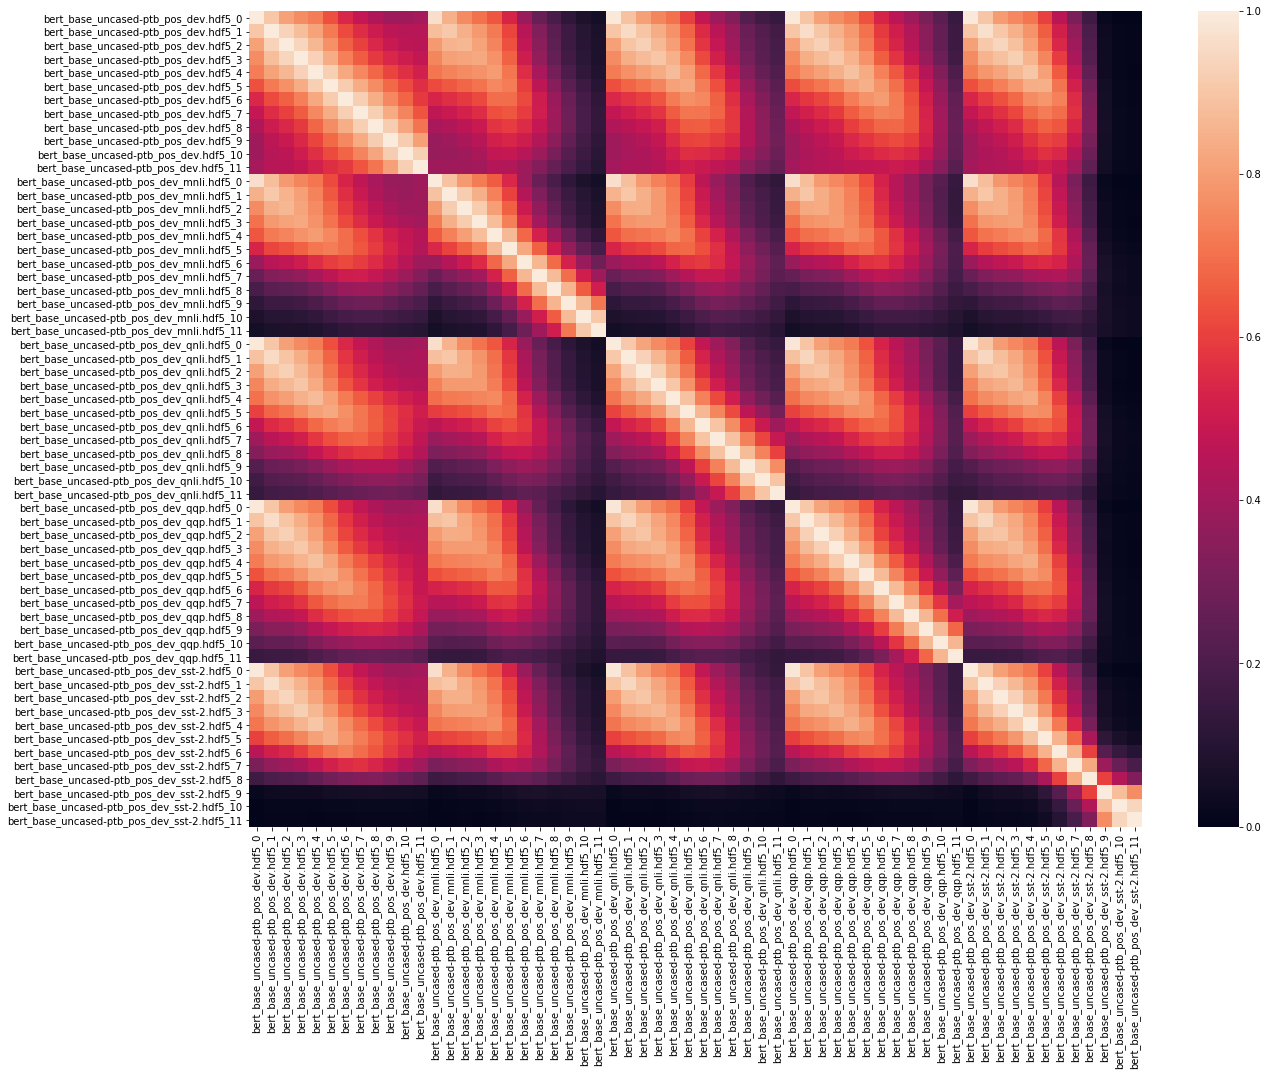

In [24]:
# lincka
sns.heatmap(lincka_df.fillna(1), vmin=0, vmax=1)

In [25]:
def corrs_update(fl, corr_df, fname_prefix, weights_df=None):
    fname = "{0}{1:.2f}.png".format(fname_prefix, fl)
    try:
        im = plt.imread(fname)
        plt.imshow(im)
    except:
        if weights_df is None: # eg. svcca, don't need to do special division
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else 
                                              t[:int(fl*len(t))].mean())
        else:
            denominator_df = weights_df.applymap(lambda t: float('nan') if type(t) is float else 
                                                             t[:int(fl*len(t))].sum())
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else
                                            t[:int(fl*len(t))].sum())
            df /= denominator_df
        sns.heatmap(df.fillna(1), vmin=0, vmax=1)
        # sns.heatmap(df.fillna(1), )
        plt.savefig(fname, transparent=True)
        plt.show()

In [26]:
# interactive updates
def pw_update(fl):
    corrs_update(fl, pw_corrs_df, "temp_fine_pw1_", weights_df=pw_alignments_df)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(pw_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [27]:
# interactive updates
def sv_update(fl):
    corrs_update(fl, sv_corrs_df, "temp_fine_sv1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(sv_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [28]:
# interactive for maxmincorr
maxmin_corrs = res_d['maxcorr']['corrs']
maxmin_corrs_df = pd.DataFrame(maxmin_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
maxmin_corrs_df = maxmin_corrs_df.reindex(maxmin_corrs_df.columns)
def maxmincorr_update(fl):
    corrs_update(fl, maxmin_corrs_df, "temp_fine_maxmincorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(maxmincorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [29]:
# interactive for linregcorr
linreg_corrs = res_d['maxlinreg']['pred_power']
linreg_corrs_df = pd.DataFrame(linreg_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
linreg_corrs_df = linreg_corrs_df.reindex(linreg_corrs_df.columns)
def linregcorr_update(fl):
    corrs_update(fl, linreg_corrs_df, "temp_fine_linregcorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(linregcorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [30]:
# rbfcka
# sns.heatmap(rbfcka_df.reindex(rbfcka_df.columns).fillna(1), vmin=0, vmax=1)

In [31]:
# # comparing models
# # use lincka
# model1 = "xlnet"
# model2 = "xlnet"
# cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
# rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

In [32]:
# df = lincka_df.loc[rows, cols]

# sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
# plt.xlabel(model1)
# plt.ylabel(model2)
# plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

# Localized vs distributed


In [37]:
locl_meth = "maxcorr"
dist_meth = "cca"

# Localized and distributed dataframes
locl_df = pd.DataFrame(res_d[locl_meth]['similarities'])
locl_df = locl_df.reindex(locl_df.columns)

dist_df = pd.DataFrame(res_d[dist_meth]['sv_similarities'])
dist_df = dist_df.reindex(dist_df.columns)

# Localization and distributivity statistics
locl_ser = locl_df.mean(axis=1)
locl_ser = (locl_ser - locl_ser.mean()) / locl_ser.std()

dist_ser = dist_df.mean(axis=1)
dist_ser = (dist_ser - dist_ser.mean()) / dist_ser.std()

# diff_ser
diff_ser = locl_ser - dist_ser

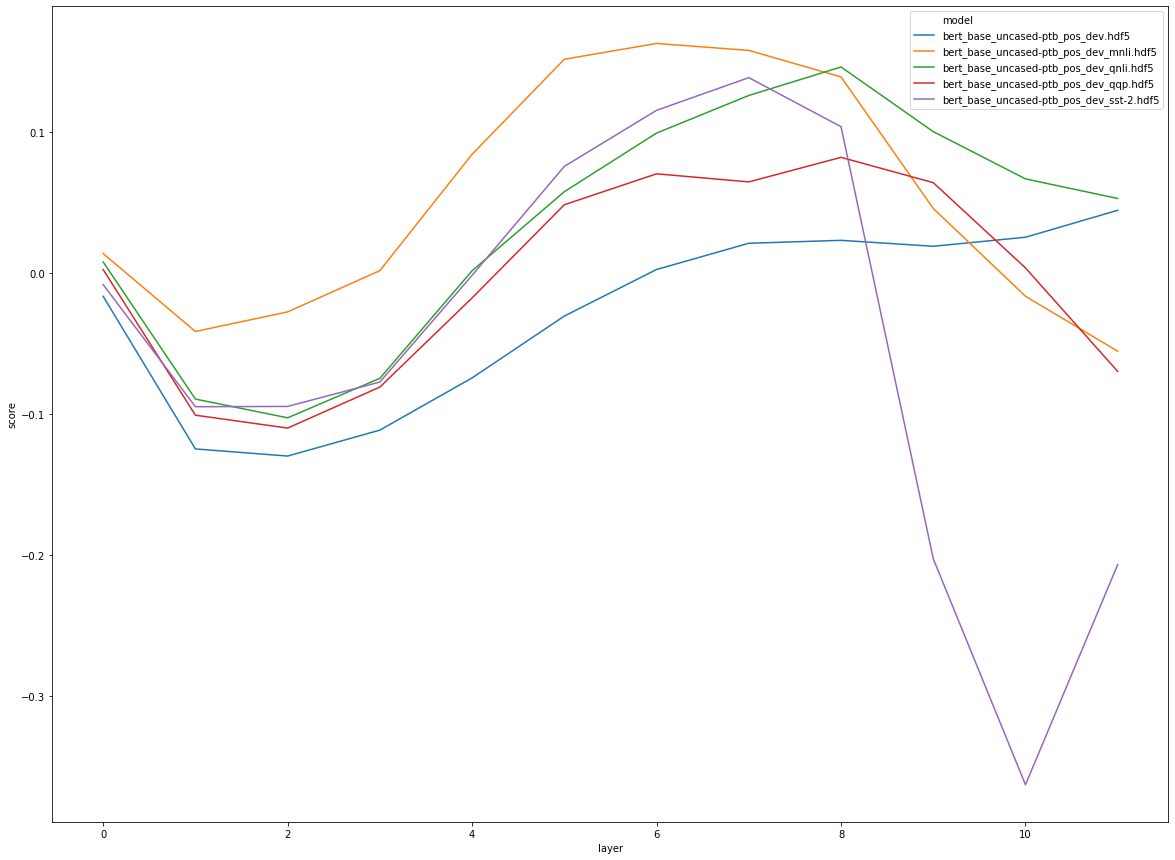

In [70]:
diff_df = pd.DataFrame(diff_ser, columns=['score'])
x = [network_sort_key(layer) for layer in diff_df.index.values]
models, layers = list(zip(*x))
# print(models)
# print(layers)
diff_df['layer'] = layers
diff_df['model'] = models
# diff_df.head()
sns.lineplot(data=diff_df, x='layer', y='score', hue='model')

In [34]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(diff_ser.sort_values())

bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10   -0.362884
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11   -0.206687
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_9    -0.202597
bert_base_uncased-ptb_pos_dev.hdf5_2          -0.129766
bert_base_uncased-ptb_pos_dev.hdf5_1          -0.124707
bert_base_uncased-ptb_pos_dev.hdf5_3          -0.111361
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2      -0.109915
bert_base_uncased-ptb_pos_dev_qnli.hdf5_2     -0.102648
bert_base_uncased-ptb_pos_dev_qqp.hdf5_1      -0.100771
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_1    -0.094768
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_2    -0.094561
bert_base_uncased-ptb_pos_dev_qnli.hdf5_1     -0.089343
bert_base_uncased-ptb_pos_dev_qqp.hdf5_3      -0.080844
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_3    -0.077260
bert_base_uncased-ptb_pos_dev_qnli.hdf5_3     -0.074624
bert_base_uncased-ptb_pos_dev.hdf5_4          -0.074328
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11     -0.069753
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11    -0

In [35]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(locl_ser.sort_values())

bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11   -2.882610
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10   -2.456514
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11    -2.142448
bert_base_uncased-ptb_pos_dev_mnli.hdf5_10    -1.854535
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11     -1.722149
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_9    -1.682931
bert_base_uncased-ptb_pos_dev_mnli.hdf5_9     -1.509074
bert_base_uncased-ptb_pos_dev_qnli.hdf5_11    -1.452696
bert_base_uncased-ptb_pos_dev_qqp.hdf5_10     -1.233126
bert_base_uncased-ptb_pos_dev_qnli.hdf5_10    -1.177214
bert_base_uncased-ptb_pos_dev_mnli.hdf5_8     -1.057148
bert_base_uncased-ptb_pos_dev_qnli.hdf5_9     -0.830849
bert_base_uncased-ptb_pos_dev_qqp.hdf5_9      -0.779789
bert_base_uncased-ptb_pos_dev.hdf5_11         -0.700871
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_8    -0.680652
bert_base_uncased-ptb_pos_dev_mnli.hdf5_7     -0.613683
bert_base_uncased-ptb_pos_dev_qnli.hdf5_8     -0.423880
bert_base_uncased-ptb_pos_dev.hdf5_10         -0

In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(dist_ser.sort_values())

bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11   -2.675924
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10   -2.093630
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11    -2.087025
bert_base_uncased-ptb_pos_dev_mnli.hdf5_10    -1.838097
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11     -1.652395
bert_base_uncased-ptb_pos_dev_mnli.hdf5_9     -1.554947
bert_base_uncased-ptb_pos_dev_qnli.hdf5_11    -1.505617
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_9    -1.480334
bert_base_uncased-ptb_pos_dev_qnli.hdf5_10    -1.244037
bert_base_uncased-ptb_pos_dev_qqp.hdf5_10     -1.236795
bert_base_uncased-ptb_pos_dev_mnli.hdf5_8     -1.196285
bert_base_uncased-ptb_pos_dev_qnli.hdf5_9     -0.931183
bert_base_uncased-ptb_pos_dev_qqp.hdf5_9      -0.843938
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_8    -0.784486
bert_base_uncased-ptb_pos_dev_mnli.hdf5_7     -0.771649
bert_base_uncased-ptb_pos_dev.hdf5_11         -0.745421
bert_base_uncased-ptb_pos_dev_qnli.hdf5_8     -0.570082
bert_base_uncased-ptb_pos_dev_qqp.hdf5_8      -0